# How many electrodes do you need to stably estimate an SSVEP?



In [1]:
# Import mne for eeg processing
import mne
# For SSVEP analysis (custom package)
import ssvepy
# import autoreject
from autoreject import LocalAutoRejectCV, Ransac
# for file operations
from glob import glob
# for numeric computing and plotting
import numpy as np
from matplotlib import pyplot as plt

# for more fun plotting
from tqdm import tqdm_notebook
from ipywidgets import interact

mne.utils.set_log_level('WARNING')

/Library/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
# parameters required for analysis

stimfreq = 6.0

fmin, fmax = 1.0, 30.0

tmin, tmax = 1.0, 15.0


In [3]:
# list the files
datafolder = '/Users/jan/Documents/eeg-data/faces-project/'
files = [file for file in glob(datafolder + '*.bdf')]

We can now start creating the information structure as well as the epoched data structures for each participant. In the following steps, we don't actually load the data into memory - we just get the meta-data to start epoching the data.

In [4]:
# create a raw class for each participant
# NB mne doesn't load the data straight away, this is just info structures
raws = [mne.io.read_raw_edf(file, eog=['EXG' + str(i) for i in range(9)],
                            montage=mne.channels.read_montage('biosemi64'),
                            verbose='WARNING')
       for file in files]
# For now, we'll just work with the EEG channels:
picks = [mne.pick_types(raw.info, eeg=True) for raw in raws]

In [5]:
# read the events
events = [mne.find_events(raw, stim_channel='STI 014', verbose='WARNING')
          for raw in raws]
# choose the events that are actual start triggers (255=end of trial)
eventids = [event[:, 2][event[:, 2] < 255].tolist()
            for event in events]

In [6]:
# epoch the data
epochs = [mne.Epochs(raw, events=event, event_id=eventid,
                     tmin=0, tmax=16, add_eeg_ref=False,
                     picks=pick,
                     verbose='WARNING')
          for raw, event, eventid, pick in zip(raws, events, eventids, picks)]

In [7]:
# pre-load the data and resample it
for epoch in epochs:
    epoch.load_data()
    epoch.resample(256)

In [8]:
# use ransac from autoreject to interpolate bad channels

cleanepochs = [Ransac(verbose='tqdm_notebook').fit_transform(epoch)
               for epoch in tqdm_notebook(epochs, desc='Subjects')]


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s finished


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s finished


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished


In this analysis we are focusing on how many electrodes you need to stably estimate an SSVEP. The SSVEP signal is strongest at the occipital pole (over V1), so we'll do this by calculating the distance from `Oz` for each electrode and sorting by that distance, then gradually add more and more electrodes, starting with the closest one.

In [9]:
mtg = mne.channels.read_montage('biosemi64')

dist = np.array(
    [np.linalg.norm(mtg.pos[idx, :]-mtg.pos[mtg.ch_names.index('Oz')])
     for idx in range(mtg.pos.shape[0])]
)
# sort the electrodes by distance from Oz
sortorder = np.argsort(dist)
# create a list containing lists of electrodes, starting at just Oz and moving upwards
electrodepicks = [[mtg.ch_names[elecindex]
                   for elecindex in sortorder[0:(loopindex+1)]
                   if mtg.ch_names[elecindex] in epochs[0].ch_names]
                  for loopindex in range(len(mtg.ch_names))]

Now that we know which timepoints we actually are interested in, we can load the data into memory and do what we need to do with it: Trim it to the right length, re-reference it, and then calculate the power spectrum density (psd).

In [16]:
ssveplists = []  # the outer list indexes subjects

# loop over our data structures:
for epoch in tqdm_notebook(cleanepochs, desc='Subjects'):

    ssveplist = []  # the inner list indexes electrodecombos

    # Now loop over the electrode combinations
    for electrodes in tqdm_notebook(electrodepicks, desc='Electrodes', leave=False):
        tmpepoch = epoch.copy()
        tmpepoch.pick_channels(electrodes)  # pick subset
        if len(electrodes) > 2:
            tmpepoch.set_eeg_reference(ref_channels=electrodes)  # reref to avg
        
        # Do the fourier transform:
        ssvep = ssvepy.Ssvep(tmpepoch, stimfreq,
                             fmin=fmin, fmax=fmax,
                             tmin=tmin, tmax=tmax)

        ssveplist.append(ssvep)  # append to list:

    # append the list to the bigger list:
    ssveplists.append(ssveplist)


Just to explore the data a bit, I'm going to implement an ipywidget plotting function here:

In [17]:
def plot_spec(subjectno, electrodecombo, spectype='snr'):
    if spectype=='snr':
        ssveplists[subjectno][electrodecombo].plot_snr()
    elif spectype=='psd':
        ssveplists[subjectno][electrodecombo].plot_psd()

interact(plot_spec,
         subjectno=(0, len(files)-1, 1),
         electrodecombo=(0, len(electrodepicks)-1, 1),
         spectype=['snr', 'psd']);

In [33]:
epoch = cleanepochs[3]
epoch.save('/Users/jan/Dropbox/Documents/side-projects/ssvepy/ssvepy/exampledata/example-epo.fif')

First, we calculate the maximal signal-to-noise ratio that we have across our electrodes:

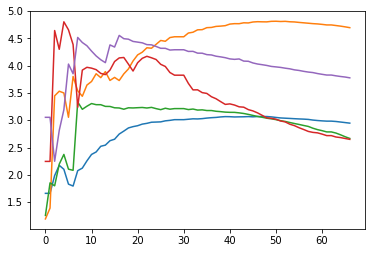

In [18]:
maxsnrs = np.array(
    [[snr[:, ((freqs >= baselinefreqs[0]-freqresolution) &
              (freqs <= baselinefreqs[0]+freqresolution))].mean(axis=1).max()
      for snr in snrlist]
     for snrlist in snrlists]
)

plt.plot(maxsnrs.T)
plt.show()

Next, we will calculate the amplitude using a variety of approaches:

1. Simply taking `Oz`
2. Taking an SNR-weighted average of the occipital pole electrodes
3. Taking the electrode with the highest SNR

['Oz', 'O2']